In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
import jax.random as jr
import jax.experimental.optimizers as optimizers
from jax import jit, value_and_grad
from tqdm.auto import trange

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

In [3]:
from ssm.models.lds import GaussianLDS
from ssm.distributions.linreg import GaussianLinearRegression

In [4]:

def random_rotation(seed, n, theta=None):
    
    key1, key2 = jr.split(seed)
    
    if theta is None:
        # Sample a random, slow rotation
        theta = 0.5 * np.pi * jr.uniform(key1)

    if n == 1:
        return jr.uniform(key1) * np.eye(1)

    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    out = np.eye(n)
    out = out.at[:2, :2].set(rot)
    q = np.linalg.qr(jr.uniform(key2, shape=(n, n)))[0]
    return q.dot(out).dot(q.T)


def plot_dynamics_2d(dynamics_matrix,
                     bias_vector,
                     mins=(-40,-40),
                     maxs=(40,40),
                     npts=20,
                     axis=None,
                     **kwargs):
    """Utility to visualize the dynamics for a 2 dimensional dynamical system.
    Args
    ----
        dynamics_matrix: 2x2 numpy array. "A" matrix for the system.
        bias_vector: "b" vector for the system. Has size (2,).
        mins: Tuple of minimums for the quiver plot.
        maxs: Tuple of maximums for the quiver plot.
        npts: Number of arrows to show.
        axis: Axis to use for plotting. Defaults to None, and returns a new axis.
        kwargs: keyword args passed to plt.quiver.
    Returns
    -------
        q: quiver object returned by pyplot
    """
    assert dynamics_matrix.shape == (2, 2), "Must pass a 2 x 2 dynamics matrix to visualize."
    assert len(bias_vector) == 2, "Bias vector must have length 2."

    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    xy_grid = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    dx = xy_grid.dot(dynamics_matrix.T) + bias_vector - xy_grid

    if axis is not None:
        q = axis.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    else:
        q = plt.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
        
    plt.gca().set_aspect(1.0)
    return q

In [5]:
emissions_dim = 10
latent_dim = 2
seed = jr.PRNGKey(0)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    0.1**2 * np.eye(latent_dim))

emissions_distribution = GaussianLinearRegression(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.zeros(emissions_dim), 
    1.0**2 * np.eye(emissions_dim))

true_lds = GaussianLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

In [6]:
# key = npr.PRNGKey(0)
# key1, key2, key3, key4, key5 = npr.split(key, 5)

# A0 = .99 * random_rotation(hidden_dim, theta=np.pi/20, key=key1)
# S = np.arange(1, hidden_dim+1)
# R = np.linalg.svd(npr.normal(key2, shape=(hidden_dim, hidden_dim)))[0] * S
# A = R.dot(A0).dot(np.linalg.inv(R))
# b = npr.normal(key3, shape=(hidden_dim,))

# C = npr.normal(key4, shape=(obs_dim, hidden_dim))
# d = npr.normal(key5, shape=(obs_dim,))

In [7]:
# # set the dynamics of our LDS object

# true_lds.transition_matrix = A
# true_lds.hidden_bias = b
# true_lds.emission_scale_tril = np.identity(hidden_dim) * 0.25

# true_lds.emission_matrix = C
# true_lds.output_bias = d
# true_lds.emission_scale_tril = np.identity(obs_dim) * 0.25

# true_lds.initial_mean = np.ones(hidden_dim)
# true_lds.initial_scale_tril = np.identity(hidden_dim) * 0.25

In [8]:
time_bins = 200
key = jr.PRNGKey(0)

states, data = true_lds.sample(key=key, num_steps=time_bins)

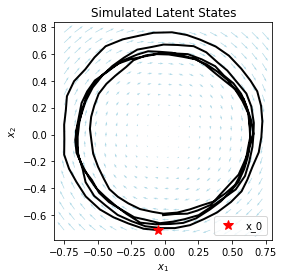

In [9]:
# Plot the dynamics vector field
q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="lightblue")

plt.plot(states[:,0], states[:,1], '-k', lw=2)
plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="x_0")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()
plt.legend()
plt.show()

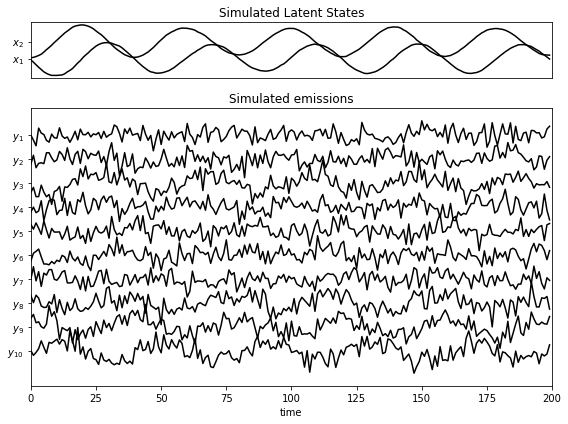

In [10]:
from matplotlib.gridspec import GridSpec 

plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states[:, d] + lim * d, '-k')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(data).max()
plt.subplot(gs[1])
for n in range(emissions_dim):
    plt.plot(data[:, n] - lim * n, '-k')
plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)

plt.title("Simulated emissions")
plt.tight_layout()

# Fit another Gaussian LDS

In [11]:
seed = jr.PRNGKey(1)

emissions_dim = 10
latent_dim = 2
seed = jr.PRNGKey(0)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    1.0**2 * np.eye(latent_dim))

emissions_distribution = GaussianLinearRegression(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.zeros(emissions_dim), 
    1.0**2 * np.eye(emissions_dim))

test_lds = GaussianLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

100%|██████████| 1000/1000 [00:05<00:00, 188.60it/s]


Text(0, 0.5, 'objective')

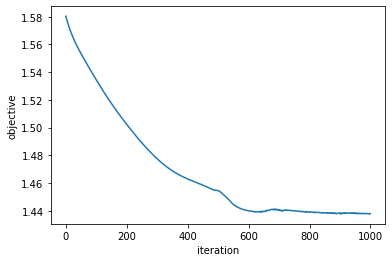

In [12]:
from ssm.inference.lds import lds_log_normalizer

learning_rate = 0.001

def objective(lds):
    lp = lds_log_normalizer(*lds.natural_parameters(data))
    return -lp / data.size

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(test_lds)

@jit
def step(step, opt_state):
    value, grads = value_and_grad(objective)(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

vals = []
for i in trange(1000):
    value, opt_state = step(i, opt_state)
    vals.append(value)

plt.plot(vals)
plt.xlabel("iteration")
plt.ylabel("objective")

LP: -2826.930: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


Text(0, 0.5, 'normalized marginal likelihood')

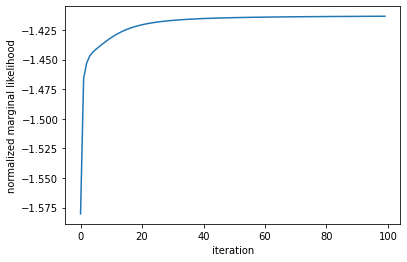

In [13]:
from ssm.inference.lds import em

lps, lds, posterior = em(test_lds, data)

plt.plot(lps / data.size)
plt.xlabel("iteration")
plt.ylabel("normalized marginal likelihood")